## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [13]:
import os
import keras

# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [14]:
train, test = keras.datasets.cifar10.load_data()

In [15]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [16]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [21]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [22]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [23]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.75]
redice_lr_patient = [5, 10]

In [24]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=reduce_patient, 
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalizatio

50000/50000 [==============================] - 41s 818us/step - loss: 1.2753 - acc: 0.5573 - val_loss: 1.5051 - val_acc: 0.4679
Epoch 12/25
50000/50000 [==============================] - 42s 834us/step - loss: 1.2491 - acc: 0.5668 - val_loss: 1.5038 - val_acc: 0.4702
Epoch 13/25
50000/50000 [==============================] - 41s 823us/step - loss: 1.2226 - acc: 0.5771 - val_loss: 1.4825 - val_acc: 0.4808
Epoch 14/25
50000/50000 [==============================] - 43s 852us/step - loss: 1.1984 - acc: 0.5850 - val_loss: 1.4729 - val_acc: 0.4803
Epoch 15/25
50000/50000 [==============================] - 40s 808us/step - loss: 1.1730 - acc: 0.5946 - val_loss: 1.4671 - val_acc: 0.4832
Epoch 16/25
50000/50000 [==============================] - 42s 846us/step - loss: 1.1466 - acc: 0.6053 - val_loss: 1.4674 - val_acc: 0.4884
Epoch 17/25
50000/50000 [==============================] - 39s 789us/step - loss: 1.1252 - acc: 0.6139 - val_loss: 1.4624 - val_acc: 0.4896
Epoch 18/25
50000/50000 [=======

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 59s 1ms/step - loss: 2.2316 - acc: 0.2616 - val_loss: 2.1215 - val_acc: 0.3128
Epoch 2/25
50000/50000 [==============================] - 42s 842us/step - loss: 1.7391 - acc: 0.3912 - val_loss: 1.8119 - val_acc: 0.3871
Epoch 3/25
50000/50000 [==============================] - 41s 827us/step - loss: 1.6143 - acc: 0.4332 - val_loss: 1.7071 - val_acc: 0.4059
Epoch 4/25
50000/50000 [==============================] - 43s 864us/step - loss: 1.5416 - acc: 0.4588 - val_loss: 1.6219 - val_acc: 0.4312
Epoch 5/25
50000/50000 [==============================] - 42s 830us/step - loss: 1.4870 - acc: 0.4809 - val_loss: 1.5987 - val_acc: 0.4386
Epoch 6/25
50000/50000 [==============================] - 43s 858us/step - loss: 1.4419 - acc: 0.4974 - val_loss: 1.5545 - val_acc: 0.4514
Epoch 7/25
50000/50000 [==============================] - 41s 829us/step - loss: 1.4017 - acc: 0.5107 - val_loss: 1.54

50000/50000 [==============================] - 44s 874us/step - loss: 0.5046 - acc: 0.8437 - val_loss: 1.5732 - val_acc: 0.5064
Epoch 23/25
50000/50000 [==============================] - 45s 906us/step - loss: 0.4814 - acc: 0.8528 - val_loss: 1.6352 - val_acc: 0.4949

Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 24/25
50000/50000 [==============================] - 45s 904us/step - loss: 0.4270 - acc: 0.8794 - val_loss: 1.5703 - val_acc: 0.5180
Epoch 25/25
50000/50000 [==============================] - 46s 922us/step - loss: 0.4036 - acc: 0.8888 - val_loss: 1.5981 - val_acc: 0.5133
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)        

50000/50000 [==============================] - 43s 868us/step - loss: 1.1105 - acc: 0.6167 - val_loss: 1.4783 - val_acc: 0.4780
Epoch 9/25
50000/50000 [==============================] - 45s 902us/step - loss: 1.0705 - acc: 0.6321 - val_loss: 1.5177 - val_acc: 0.4671
Epoch 10/25
50000/50000 [==============================] - 43s 854us/step - loss: 1.0326 - acc: 0.6475 - val_loss: 1.4497 - val_acc: 0.4874
Epoch 11/25
50000/50000 [==============================] - 45s 893us/step - loss: 0.9957 - acc: 0.6590 - val_loss: 1.4599 - val_acc: 0.4872
Epoch 12/25
50000/50000 [==============================] - 43s 868us/step - loss: 0.9615 - acc: 0.6734 - val_loss: 1.5397 - val_acc: 0.4648
Epoch 13/25
50000/50000 [==============================] - 45s 893us/step - loss: 0.9275 - acc: 0.6844 - val_loss: 1.4377 - val_acc: 0.4973
Epoch 14/25
50000/50000 [==============================] - 44s 878us/step - loss: 0.8924 - acc: 0.6990 - val_loss: 1.4452 - val_acc: 0.4927
Epoch 15/25
50000/50000 [========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 66s 1ms/step - loss: 1.8050 - acc: 0.3735 - val_loss: 2.1395 - val_acc: 0.3116
Epoch 2/25
50000/50000 [==============================] - 44s 885us/step - loss: 1.5310 - acc: 0.4613 - val_loss: 2.3137 - val_acc: 0.2979
Epoch 3/25
50000/50000 [==============================] - 44s 876us/step - loss: 1.4289 - acc: 0.4957 - val_loss: 2.3521 - val_acc: 0.2604
Epoch 4/25
50000/50000 [==============================] - 42s 847us/step - loss: 1.3563 - acc: 0.5197 - val_loss: 2.1146 - val_acc: 0.2935
Epoch 5/25
50000/50000 [==============================] - 44s 877us/step - loss: 1.3022 - acc: 0.5399 - val_loss: 2.0096 - val_acc: 0.3345
Epoch 6/25
50000/50000 [==============================] - 44s 873us/step - loss: 1.2543 - acc: 0.5583 - val_loss: 2.0879 - val_acc: 0.3140
Epoch 7/25
50000/50000 [==============================] - 43s 867us/step - loss: 1.2143 - acc: 0.5702 - val_loss: 2.13

50000/50000 [==============================] - 42s 845us/step - loss: 0.7060 - acc: 0.7651 - val_loss: 1.6878 - val_acc: 0.4601
Epoch 23/25
50000/50000 [==============================] - 43s 858us/step - loss: 0.6940 - acc: 0.7689 - val_loss: 1.7559 - val_acc: 0.4452
Epoch 24/25
50000/50000 [==============================] - 47s 950us/step - loss: 0.6629 - acc: 0.7805 - val_loss: 1.8497 - val_acc: 0.4259

Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 25/25
50000/50000 [==============================] - 42s 839us/step - loss: 0.5598 - acc: 0.8279 - val_loss: 1.5533 - val_acc: 0.4909
Numbers of exp: 10, reduce_factor: 0.75, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)        

50000/50000 [==============================] - 41s 827us/step - loss: 1.3120 - acc: 0.5437 - val_loss: 1.6190 - val_acc: 0.4357
Epoch 8/25
50000/50000 [==============================] - 41s 824us/step - loss: 1.2717 - acc: 0.5593 - val_loss: 1.5514 - val_acc: 0.4614
Epoch 9/25
50000/50000 [==============================] - 42s 835us/step - loss: 1.2343 - acc: 0.5755 - val_loss: 1.5292 - val_acc: 0.4619
Epoch 10/25
50000/50000 [==============================] - 43s 852us/step - loss: 1.1978 - acc: 0.5884 - val_loss: 1.5105 - val_acc: 0.4735
Epoch 11/25
50000/50000 [==============================] - 53s 1ms/step - loss: 1.1648 - acc: 0.6010 - val_loss: 1.5171 - val_acc: 0.4663
Epoch 12/25
50000/50000 [==============================] - 47s 932us/step - loss: 1.1322 - acc: 0.6128 - val_loss: 1.5308 - val_acc: 0.4701
Epoch 13/25
50000/50000 [==============================] - 49s 980us/step - loss: 1.1020 - acc: 0.6227 - val_loss: 1.5114 - val_acc: 0.4731
Epoch 14/25
50000/50000 [===========

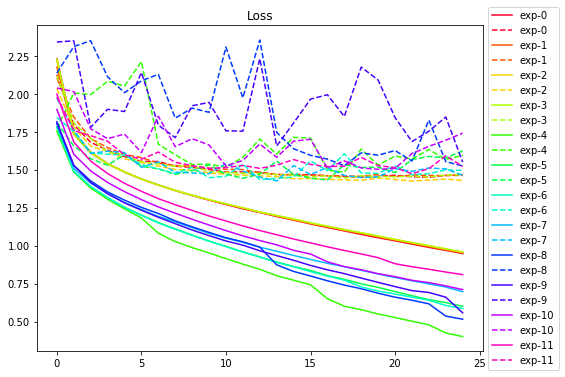

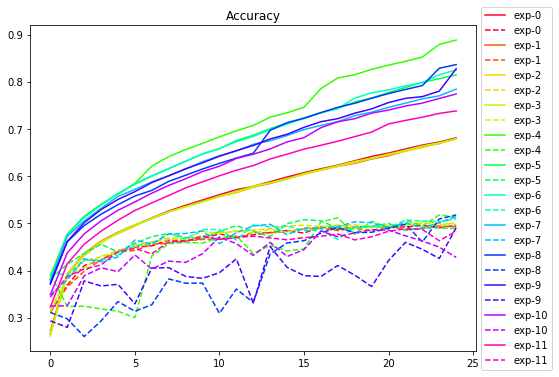

In [25]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [20]:
x_train

array([[0.23137255, 0.24313725, 0.24705882, ..., 0.48235294, 0.36078431,
        0.28235294],
       [0.60392157, 0.69411765, 0.73333333, ..., 0.56078431, 0.52156863,
        0.56470588],
       [1.        , 1.        , 1.        , ..., 0.31372549, 0.3372549 ,
        0.32941176],
       ...,
       [0.1372549 , 0.69803922, 0.92156863, ..., 0.04705882, 0.12156863,
        0.19607843],
       [0.74117647, 0.82745098, 0.94117647, ..., 0.76470588, 0.74509804,
        0.67058824],
       [0.89803922, 0.89803922, 0.9372549 , ..., 0.63921569, 0.63921569,
        0.63137255]])